In [1]:
from qiskit import QuantumRegister, ClassicalRegister, QuantumCircuit

In [2]:
#%pip install ipympl
#%matplotlib ipympl

try:
  import matplotlib.pyplot as plt
  from qiskit.quantum_info import partial_trace,Statevector
  import qiskit 
  from qiskit_aer.noise import NoiseModel, pauli_error
  from qiskit_aer import AerSimulator
  from qiskit import transpile
except:
  !pip install matplotlib qiskit[visualization] qiskit_aer
  import matplotlib.pyplot as plt
  from qiskit.quantum_info import partial_trace,Statevector
  import qiskit 
  from qiskit_aer.noise import NoiseModel, pauli_error
  from qiskit_aer import AerSimulator
  from qiskit import transpile

### helper stuff 
def pauli_error_x(err, _):
    return pauli_error([('I', 1 - err), ('X', err)])


def pauli_error_z(err, _):
    return pauli_error([('I', 1 - err), ('Z', err)])

def pauli_error_y(err, _):
    return pauli_error([('I', 1 - err), ('Y', err)])

def run_with_error(qc, id_error, shots=100, opt_level=0):
    noise_model = NoiseModel()
    noise_model.add_all_qubit_quantum_error(id_error, 'id')
    sim = AerSimulator(method='matrix_product_state', noise_model=noise_model)
    # sim = Aer.get_backend('qasm_simulator')

    transpiled_qc = transpile(qc, sim, optimization_level=opt_level)
    res = sim.run(transpiled_qc, shots=shots).result()
    return res



def test_quantum_qec(qc_enc: qiskit.QuantumCircuit | None = None, qc_syndrome: qiskit.QuantumCircuit | None = None,
                     qc_correct: qiskit.QuantumCircuit | None = None,
                     qc_decode: qiskit.QuantumCircuit | None = None, qc_type=0):
    # 0: bitlfip
    # 1: phaseflip
    # 2: shor
    pad_bits = 4
    err_to_apply = qiskit.circuit.library.IGate
    err_model = pauli_error_x
    channe_qbits = 3
    if qc_type == 0:
        err_to_apply = qiskit.circuit.library.XGate
    elif qc_type == 1:
        err_to_apply = qiskit.circuit.library.ZGate
        err_model = pauli_error_z
    elif qc_type == 2:
        pad_bits = 16
        err_to_apply = qiskit.circuit.library.YGate
        channe_qbits = 9
        err_model = pauli_error_y

    sv = None
    sv_res = None
    failed = False

    for i in range(channe_qbits):
        sv = qiskit.quantum_info.random_statevector(2, seed=209)
        sv = sv.from_label("0" * pad_bits).tensor(sv)

        qc = qiskit.QuantumCircuit(qc_enc.num_qubits)
        qc.compose(qc_enc, inplace=True, wrap=True)

        qc.append(err_to_apply(), qargs=[i])

        qc.barrier(label="Errors")

        if qc_syndrome:
            qc.compose(qc_syndrome, inplace=True, wrap=True)

        if qc_correct:
            qc.compose(qc_correct, inplace=True, wrap=True)


        if qc_decode:
            qc.compose(qc_decode, inplace=True, wrap=True)

        #qc.draw("mpl")

        sv_res = sv.evolve(qc)
        sv = partial_trace(sv, [i for i in range(1, pad_bits + 1)])
        sv_res = partial_trace(sv_res, [i for i in range(1, pad_bits + 1)])

        if sv == sv_res:
            continue
        failed = True
        print(f"Error when applying error to the {i}th channel bit!")

    if failed:
        return 
        
    print("Your QEC is working as intended congratulations!")
    qc = qiskit.QuantumCircuit(qc_enc.num_qubits,1)
    
    
    
    qc.x(0)
    
    qc.compose(qc_enc, inplace=True, wrap=True)

    for i in range(channe_qbits):
        qc.id(i)

    qc.barrier(label="Errors")

    if qc_syndrome:
        qc.compose(qc_syndrome, inplace=True, wrap=True)

    if qc_correct:
        qc.compose(qc_correct, inplace=True, wrap=True)

    if qc_decode:
        qc.compose(qc_decode, inplace=True, wrap=True)
        
    qc.measure(0,0)
    
    fids = []
    errs = []
    n= 50
    for k in range(n):
        max_err=  0.5
        use_err = k/n*max_err
        results = run_with_error(qc,id_error=err_model(use_err,None))
        try:
            fidelity = results.get_counts()["1"]/100
        except:
            fidelity =0
        
        fids.append(fidelity)
        errs.append(use_err)
    
    
    plt.xlabel('Error chance')
    plt.ylabel('Fidelity')
    plt.plot(errs,fids)


# Creating code to correct a simple bit-flip error
### Encoding:

Create a quantum circuit that encodes the input quantum bit into the desired logical state:

$|\phi> = \alpha|0> +\beta|1>$ -> $\alpha|000> +\beta|111>$
 
 

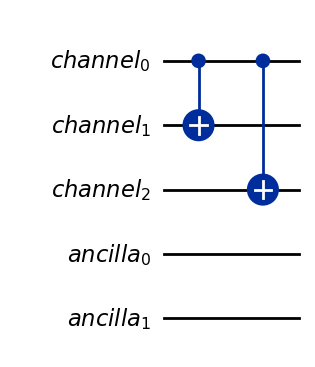

In [3]:
channel = qiskit.QuantumRegister(3, name="channel") #3 qubits for the logical state
ancillas = qiskit.QuantumRegister(2, name="ancilla") #2 ancilliary qubit
qc_encode = qiskit.QuantumCircuit(channel,ancillas,name="enc")

### Your code goes here

# Encoding
qc_encode.cx(channel[0],channel[1])
qc_encode.cx(channel[0],channel[2])

###
qc_encode.draw("mpl")

### Using the StateVector object test your code!

In [4]:
# stateVector object allows to simulate and visualize the quantum state from
# our circuit before and after encoding

sv = Statevector.from_label("00001")

sv_res = sv.evolve(qc_encode)

###
sv_res.draw("Latex")

<IPython.core.display.Latex object>

### Error detection 

Create a quantum circuit that projects the errors into the ancilla quantum bits.

### Help:
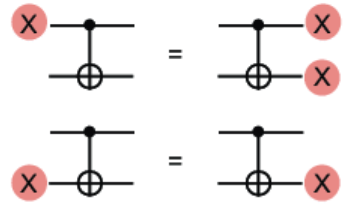

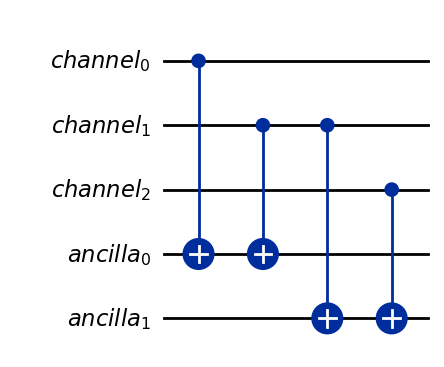

In [5]:
channel = qiskit.QuantumRegister(3, 'channel')
ancillas = qiskit.QuantumRegister(2, 'ancilla')
qc_shor_bit = qiskit.QuantumCircuit(channel, ancillas, name="syn")

# Apply CNOT gates to detect bit-flip errors
qc_shor_bit.cx(channel[0], ancillas[0])
qc_shor_bit.cx(channel[1], ancillas[0])

qc_shor_bit.cx(channel[1], ancillas[1])
qc_shor_bit.cx(channel[2], ancillas[1])

###
qc_shor_bit.draw("mpl")

### Using the StateVector object test your code!

In [6]:
sv_res = sv_res.evolve(qc_shor_bit)

###
sv_res.draw("Latex")

<IPython.core.display.Latex object>

### Correcting errors 
Create a quantum circuit that with the use of ancilla quantum bits corrects the errors!

### Help
the CCX gate can be used as an indexing function

If you want it to activate for only set '10' use X gate on the second ancilla or with the ctrl_state parameter

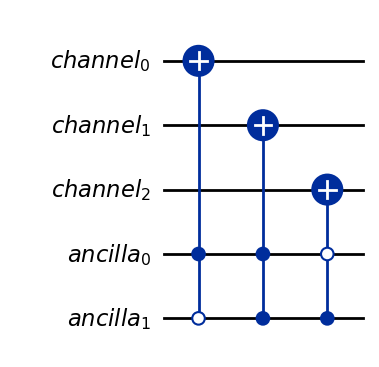

In [8]:
channel = qiskit.QuantumRegister(3, 'channel')
ancillas = qiskit.QuantumRegister(2, 'ancilla')
qc_correct = qiskit.QuantumCircuit(channel,ancillas,name="corr")

### Your code goes here

# Syn01: error qubit 2 
qc_correct.ccx(ancillas[0],ancillas[1],channel[0],ctrl_state="01")
# Syn11: error qubit 3
qc_correct.ccx(ancillas[0],ancillas[1],channel[1],ctrl_state="11")
# Syn10: error qubit 1
qc_correct.ccx(ancillas[0],ancillas[1],channel[2],ctrl_state="10")


###
qc_correct.draw("mpl")

### Using the StateVector object test your code!


In [9]:
# Get the resulting statevector
sv_res = sv_res.evolve(qc_correct)

###
sv_res.draw("Latex")

<IPython.core.display.Latex object>

### Decode

Create a quanum circuit that tranforms back the logical state in to the original 1 quantum bit state!

$|\phi> = \alpha|0> +\beta|1>$

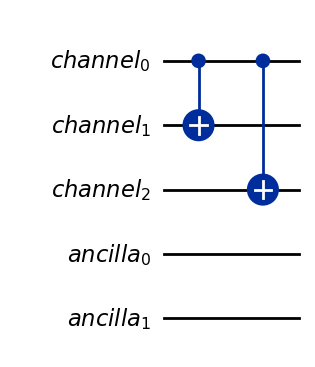

In [ ]:
channel = qiskit.QuantumRegister(3, 'channel')
ancillas = qiskit.QuantumRegister(2, 'ancilla')
qc_decode = qiskit.QuantumCircuit(channel,ancillas,name="dec")

### Your code goes here

qc_decode.cx(channel[0], channel[1])  # Undo first CNOT
qc_decode.cx(channel[0], channel[2])  # Undo second CNOT

###
qc_decode.draw("mpl")

### Using the StateVector object test your code!

In [11]:
sv_res = sv_res.evolve(qc_decode)


###
sv_res.draw("Latex")

<IPython.core.display.Latex object>

### And we are done! 

Use the following code to test your solution!
 

Your QEC is working as intended congratulations!


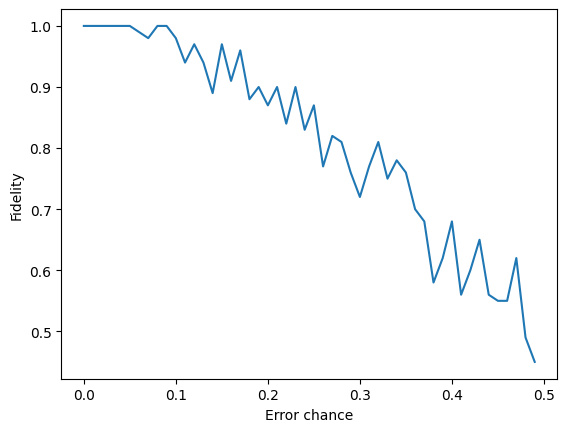

In [12]:
#Qecc test
plt.close()
test_quantum_qec(qc_enc=qc_encode, qc_syndrome=qc_shor_bit, qc_correct=qc_correct, qc_decode=qc_decode, qc_type=0)


### Congrats! Using the circuits created until now create a phase-flip (Z) error correcting circuit!

##### Hint:
Phase-flip errors can be transformed into bitflip errors using a Hadamard gate!



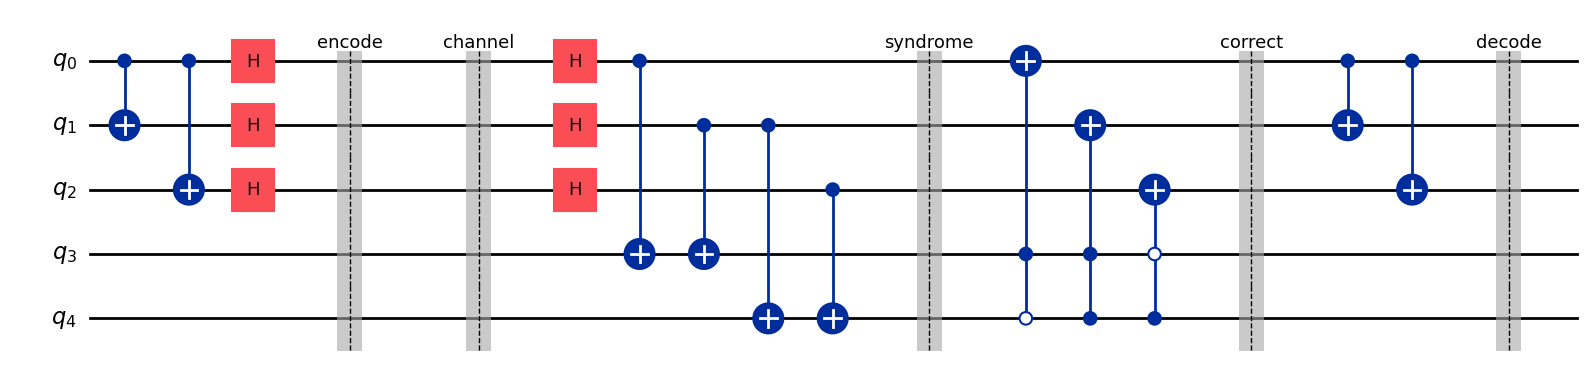

In [21]:
ph_enc = qc_encode.copy()
ph_syn = qc_shor_bit.copy()
ph_cor = qc_correct.copy()
ph_dec = qc_decode.copy()

### Your code goes here

# H gate
ph_enc.h([0, 1, 2])

# New circuit for H gate before syndrome check
pre_syndrome = qiskit.QuantumCircuit(ph_syn.num_qubits)
pre_syndrome.h([0, 1, 2])

# Combinatino of the circuits
ph_syn = pre_syndrome.compose(ph_syn)

###
qc_ph = qiskit.QuantumCircuit(ph_enc.num_qubits)
qc_ph.compose(ph_enc, inplace=True)
qc_ph.barrier(label="encode")
qc_ph.barrier(label="channel")
qc_ph.compose(ph_syn, inplace=True)
qc_ph.barrier(label="syndrome")
qc_ph.compose(ph_cor, inplace=True)
qc_ph.barrier(label="correct")
qc_ph.compose(ph_dec, inplace=True)
qc_ph.barrier(label="decode")

qc_ph.draw("mpl")

### Lets see if it works!

Your QEC is working as intended congratulations!


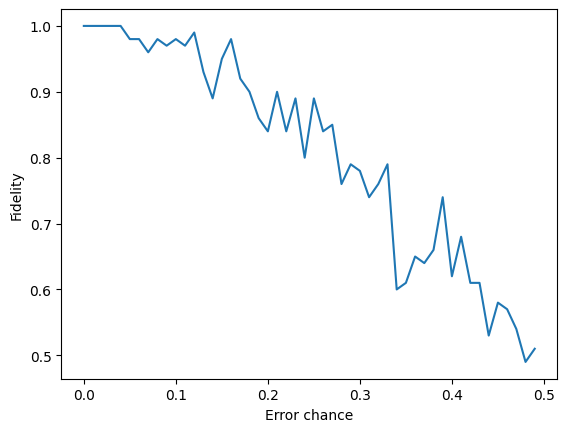

In [22]:
### QEC test
plt.close()
test_quantum_qec(qc_enc=ph_enc,qc_syndrome=ph_syn,qc_correct=ph_cor,qc_decode=ph_dec,qc_type=1)

### From these two circuits implement Shor's code!


Your QEC is working as intended congratulations!


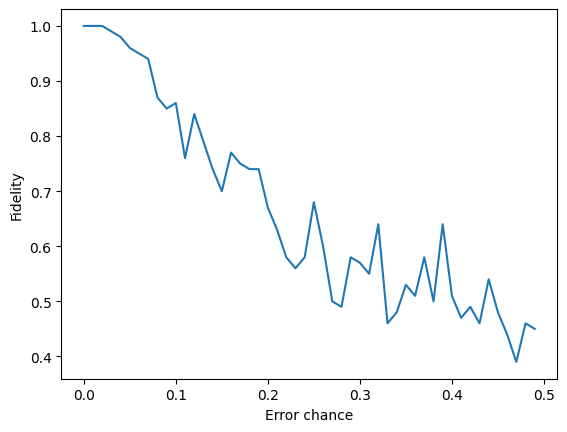

In [60]:
channel = qiskit.QuantumRegister(9, name="channel")
ancillas = qiskit.QuantumRegister(8, name="ancilla")
qc_shor = qiskit.QuantumCircuit(channel, ancillas, name="enc")

### Your code here

# 1.Bit-flip encoding
qc_shor.cx(channel[0], channel[3])
qc_shor.cx(channel[0], channel[6])

# 2.Hadamard gates for phase encoding
for i in [0, 3, 6]:
    qc_shor.h(channel[i])

# 3.Bit-flip encoding within each block
for i in [0, 3, 6]:
    qc_shor.cx(channel[i], channel[i+1])
    qc_shor.cx(channel[i], channel[i+2])

### BIT-FLIP ERROR DETECTION & CORRECTION
qc_shor_bit = qiskit.QuantumCircuit(channel, ancillas, name="bitflip")
qc_shor_bit.barrier()
### Your code here

# 1.Syndrome extraction for bit-flip errors
for block, anc in zip([0, 3, 6], [0, 2, 4]):
    qc_shor_bit.cx(channel[block], ancillas[anc])
    qc_shor_bit.cx(channel[block+1], ancillas[anc])
    qc_shor_bit.cx(channel[block+1], ancillas[anc+1])
    qc_shor_bit.cx(channel[block+2], ancillas[anc+1])

qc_shor_bit.barrier()

# 2.Correction using CCX gates
for block, anc in zip([0, 3, 6], [0, 2, 4]):
    qc_shor_bit.ccx(ancillas[anc], ancillas[anc+1], channel[block], ctrl_state="01")
    qc_shor_bit.ccx(ancillas[anc], ancillas[anc+1], channel[block+1], ctrl_state="11")
    qc_shor_bit.ccx(ancillas[anc], ancillas[anc+1], channel[block+2], ctrl_state="10")

qc_shor_bit.barrier()

# 3.Decoding bit-flip encoding
for i in [0, 3, 6]:
    qc_shor_bit.cx(channel[i], channel[i+1])
    qc_shor_bit.cx(channel[i], channel[i+2])

qc_shor_bit.barrier()

### PHASE-FLIP ERROR DETECTION & CORRECTION
qc_shor_phase = qiskit.QuantumCircuit(channel, ancillas, name="phaseflip")
### Your code here

# 1.Convert phase-flip errors into bit-flip errors with Hadamards gate
for i in [0, 3, 6]:
    qc_shor_phase.h(channel[i])
qc_shor_phase.barrier()

# 2. Syndrome extraction for phase errors
qc_shor_phase.cx(channel[0], ancillas[6])
qc_shor_phase.cx(channel[3], ancillas[6])
qc_shor_phase.cx(channel[3], ancillas[7])
qc_shor_phase.cx(channel[6], ancillas[7])
qc_shor_phase.barrier()

# 3.Correction for phase errors with CCX gates
qc_shor_phase.ccx(ancillas[6], ancillas[7], channel[0], ctrl_state="01")
qc_shor_phase.ccx(ancillas[6], ancillas[7], channel[3], ctrl_state="11")
qc_shor_phase.ccx(ancillas[6], ancillas[7], channel[6], ctrl_state="10")
qc_shor_phase.barrier()

# 5.Decode phase encoding
qc_shor_phase.cx(channel[0], channel[3])
qc_shor_phase.cx(channel[0], channel[6])
qc_shor_phase.barrier()

#####

test_quantum_qec(qc_enc=qc_shor, qc_syndrome=qc_shor_bit, qc_correct=qc_shor_phase, qc_type=2)


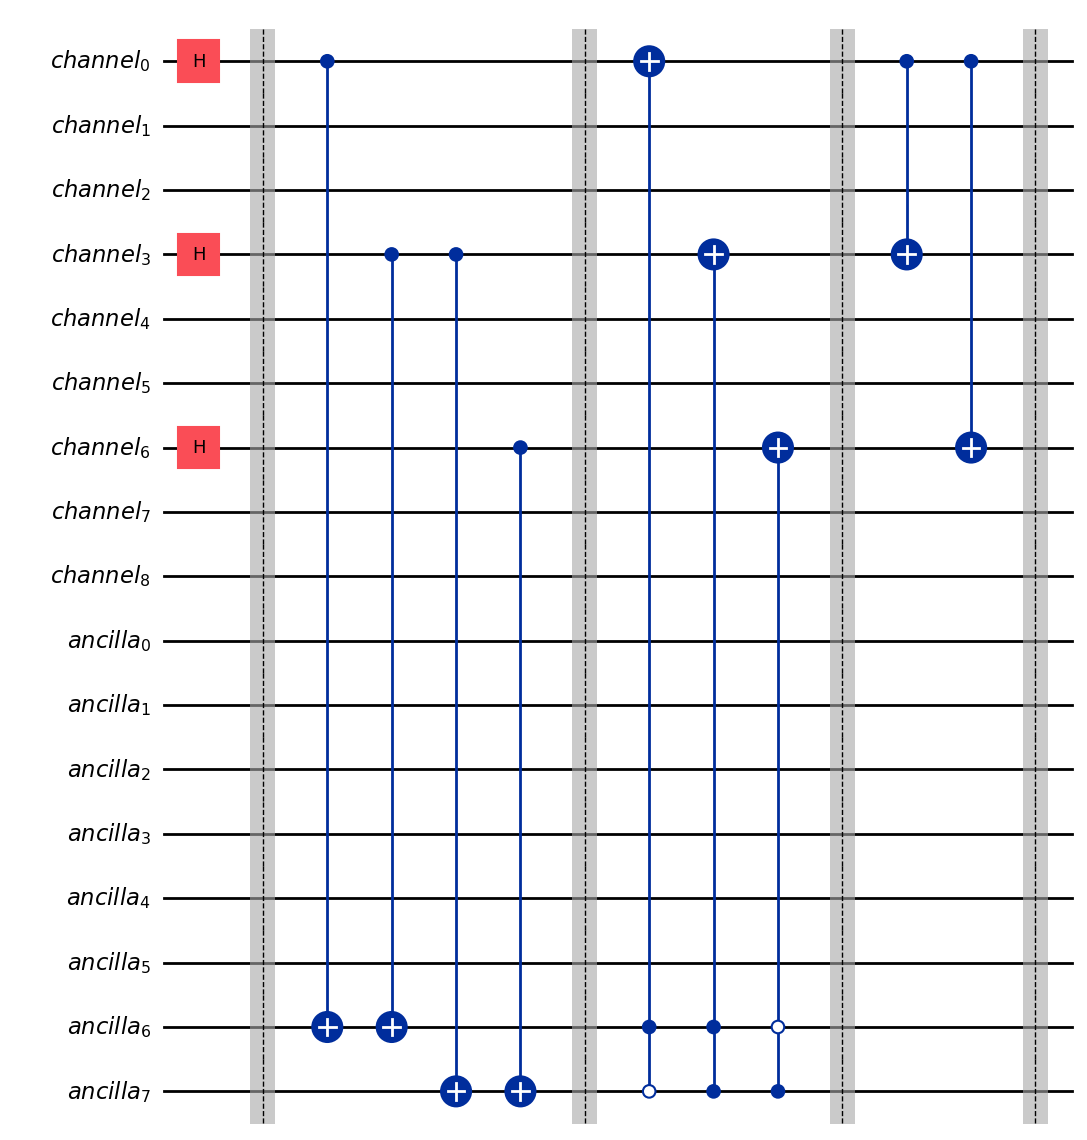

In [61]:
qc_shor.draw("mpl")
qc_shor_bit.draw("mpl")
qc_shor_phase.draw("mpl")

### Extra exercises:
+ Bit-flip QECC with no ancillas
+ Phase-flip QECC with no ancillas 
+ Shor QECC with no ancillas

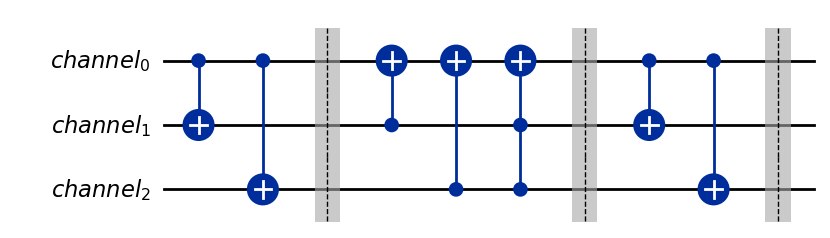

In [94]:
# Define register for encoded qubits
channel = QuantumRegister(3, name="channel")
qc_ec = QuantumCircuit(channel, name="bitflip_no_ancillas")

# Encoding
qc_ec.cx(channel[0], channel[1])
qc_ec.cx(channel[0], channel[2])

qc_ec.barrier()

# Error correction
qc_ec.cx(channel[1], channel[0])
qc_ec.cx(channel[2], channel[0])
qc_ec.ccx(channel[1], channel[2], channel[0])

qc_ec.barrier()

# Decoding
qc_ec.cx(channel[0], channel[1])
qc_ec.cx(channel[0], channel[2])

qc_ec.barrier()

# Display the circuit
qc_ec.draw("mpl")

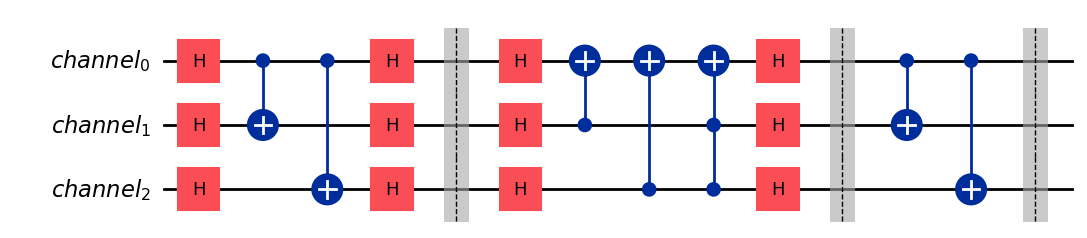

In [95]:
channel = QuantumRegister(3, name="channel")
qc_correct = QuantumCircuit(channel, name="phaseflip_no_ancillas")

# Encoding
qc_correct.h(channel)
qc_correct.cx(channel[0], channel[1])
qc_correct.cx(channel[0], channel[2])
qc_correct.h(channel)

qc_correct.barrier()

# Error correction
qc_correct.h(channel)
qc_correct.cx(channel[1], channel[0])
qc_correct.cx(channel[2], channel[0])
qc_correct.ccx(channel[1], channel[2], channel[0])
qc_correct.h(channel)

qc_correct.barrier()

# Decoding
qc_correct.cx(channel[0], channel[1])
qc_correct.cx(channel[0], channel[2])

qc_correct.barrier()

# Display the circuit
qc_correct.draw("mpl")

In [101]:


#test_quantum_qec(qc_enc=qc_ec, qc_syndrome=qc_correct,qc_type=0)


